In [1]:
import pandas as pd
import datetime
import yfinance as yf
import backtrader as bt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Date range
start = '2000-01-01'
end = '2020-12-31'

# Tickers of assets
benchmark_index = "^BSESN"
assets = """AXISBANK.NS	BPCL.NS	BRITANNIA.NS	CIPLA.NS	DRREDDY.NS	EICHERMOT.NS	GAIL.NS	HDFCBANK.NS	HINDALCO.NS	HINDUNILVR.NS	INFY.NS	IOC.NS	ITC.NS	M&M.NS	MARICO.NS	ONGC.NS	RELIANCE.NS	SAIL.NS	SBIN.NS	SIEMENS.NS	SUNPHARMA.NS	TATACONSUM.NS	TATAMOTORS.NS	TATAPOWER.NS	TATASTEEL.NS	TITAN.NS VEDL.NS	WIPRO.NS ^BSESN""".split()
assets.sort()

# Downloading data
prices = yf.download(assets, start=start, end=end)
display(prices.head())
prices = prices.dropna()

[*****                 10%                       ]  3 of 29 completed

KeyboardInterrupt: 

[*******               14%                       ]  4 of 29 completed

In [ ]:
############################################################
# Showing data
############################################################

display(prices.head())

Adj Close                                                  \
           AXISBANK.NS    BPCL.NS BRITANNIA.NS    CIPLA.NS  DRREDDY.NS   
Date                                                                     
2000-01-03    3.699342  13.014569    54.370880  100.327545  324.122803   
2000-01-04    3.842174  12.077394    54.202076  100.871414  350.061218   
2000-01-05    3.742191  11.733490    52.819271   98.792381  336.973846   
2000-01-06    3.649351  12.396849    56.436115   93.340050  357.067017   
2000-01-07    3.470811  12.382178    60.950855   85.884399  328.603455   

                                                                         ...  \
           EICHERMOT.NS   GAIL.NS HDFCBANK.NS HINDALCO.NS HINDUNILVR.NS  ...   
Date                                                                     ...   
2000-01-03     2.891770  4.213369   14.292336   57.240555    135.385193  ...   
2000-01-04     3.042721  4.069245   14.611811   59.411533    133.830338  ...   
2000-01-05     3.288389  3.876055   14.035913   64.162613    129.069290  ...   
2000-01-06     3.551815  3.983384   14.149416   69.184219    134.249954  ...   
2000-01-07     3.827082  3.842324   14.153617   72.252625    141.569092  ...   

               Volume                                                        \
           SIEMENS.NS SUNPHARMA.NS TATACONSUM.NS TATAMOTORS.NS TATAPOWER.NS   
Date                                                                          
2000-01-03    5868160       390399     1637610.0       3528277     994997.0   
2000-01-04    5128620       747102      837330.0       3544397    1058302.0   
2000-01-05    2141030       788156      854660.0       5849540     873414.0   
2000-01-06    2027820       448235     1328510.0      10274966    2088480.0   
2000-01-07     924060       532538     3353820.0      11477451     514643.0   

                                                           
           TATASTEEL.NS TITAN.NS  VEDL.NS WIPRO.NS ^BSESN  
Date                                                       
2000-01-03     35678775   460000   814840    42639    0.0  
2000-01-04     27698564   526000   894640   117119    0.0  
2000-01-05     68399389   412000   732200  3527919    0.0  
2000-01-06     45604218   632000  1032000  1942399    0.0  
2000-01-07     64862245   732000   694440   269599    0.0  

[5 rows x 174 columns]

## 2. Building the Backtest Function with Backtrader

### 2.1 Defining Backtest Function

In [ ]:
############################################################
# Defining the backtest function 
############################################################

def backtest(datas, strategy, start, end, plot=False, **kwargs):
    cerebro = bt.Cerebro()

    # Here we add transaction costs and other broker costs
    cerebro.broker.setcash(1000000.0)
    cerebro.broker.setcommission(commission=0.005) # Commission 0.5%
    cerebro.broker.set_slippage_perc(0.005, # Slippage 0.5%
                                     slip_open=True,
                                     slip_limit=True,
                                     slip_match=True,
                                     slip_out=False)
    for data in datas:
        cerebro.adddata(data)

    # Here we add the indicators that we are going to store
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    results = cerebro.run(stdstats=False)
    if plot:
        cerebro.plot(iplot=False, start=start, end=end)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

### 2.2 Building Data Feeds for Backtesting

In [ ]:
############################################################
# Create objects that contain the prices of assets
############################################################

# Creating Assets bt.feeds
assets_prices = []
for i in assets:
    if i != benchmark_index:
        prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), i)].dropna()
        prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
        assets_prices.append(bt.feeds.PandasData(dataname=prices_, plot=False))

# Creating Benchmark bt.feeds        
prices_ = prices.drop(
    columns='Adj Close').loc[:, (slice(None), benchmark_index)].dropna()
prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
benchmark = bt.feeds.PandasData(dataname=prices_, plot=False)

display(prices_.head())

,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,5375.109863,5384.660156,5209.540039,5209.540039,0.0
2000-01-04,5491.009766,5533.979980,5376.430176,5533.979980,0.0
2000-01-05,5357.000000,5464.350098,5184.479980,5265.089844,0.0
2000-01-06,5421.529785,5489.859863,5391.330078,5424.209961,0.0
2000-01-07,5414.479980,5463.250000,5330.580078,5358.279785,0.0


## 3. Building Strategies with Backtrader

### 3.1 Buy and Hold SPY

In [ ]:
############################################################
# Building the Buy and Hold strategy
############################################################

class BuyAndHold(bt.Strategy):

    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter >= 1004:
            if self.getposition(self.data).size == 0:
                self.order_target_percent(self.data, target=0.99)
        self.counter += 1 

If you have an error related to 'warnings' modules when you try to plot, you must modify the 'locator.py' file from backtrader library following the instructions in this __[link](https://community.backtrader.com/topic/981/importerror-cannot-import-name-min_per_hour-when-trying-to-plot/8)__.

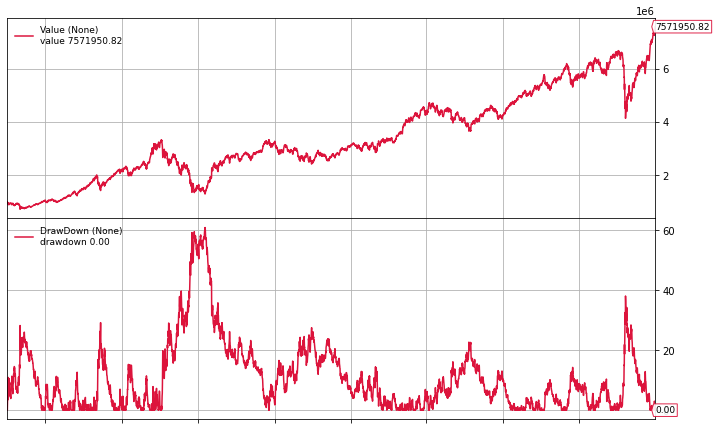

In [ ]:
############################################################
# Run the backtest for the selected period
############################################################
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.plot() # We need to do this to avoid errors in inline plot

start = 1004
end = prices.shape[0] - 1

dd, cagr, sharpe = backtest([benchmark],
                            BuyAndHold,
                            start=start,
                            end=end,
                            plot=True)

In [ ]:
############################################################
# Show Buy and Hold Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 60.88%
CAGR: 10.37%
Sharpe: 0.506


### 3.2 Rebalancing Quarterly using Riskfolio-Lib

In [ ]:
############################################################
# Calculate assets returns
############################################################

pd.options.display.float_format = '{:.4%}'.format

data = prices.loc[:, ('Adj Close', slice(None))]
data.columns = assets
data = data.drop(columns=[benchmark_index]).dropna()
returns = data.pct_change().dropna()
display(returns.head())

,AXISBANK.NS,BPCL.NS,BRITANNIA.NS,CIPLA.NS,DRREDDY.NS,EICHERMOT.NS,GAIL.NS,HDFCBANK.NS,HINDALCO.NS,HINDUNILVR.NS,...,SBIN.NS,SIEMENS.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATAPOWER.NS,TATASTEEL.NS,TITAN.NS,VEDL.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,3.8610%,-7.2010%,-0.3105%,0.5421%,8.0027%,5.2200%,-3.4206%,2.2353%,3.7927%,-1.1485%,...,6.3411%,0.2936%,-1.3405%,-2.4092%,-3.9447%,0.1954%,-1.0823%,-5.3308%,-1.4181%,8.0005%
2000-01-05,-2.6022%,-2.8475%,-2.5512%,-2.0611%,-3.7386%,8.0740%,-4.7476%,-3.9413%,7.9969%,-3.5575%,...,-4.1104%,-4.4003%,-3.5102%,-4.1659%,2.4256%,1.9506%,3.8130%,-6.1058%,-0.6103%,1.6298%
2000-01-06,-2.4809%,5.6535%,6.8476%,-5.5190%,5.9628%,8.0108%,2.7690%,0.8087%,7.8264%,4.0139%,...,5.0513%,1.4354%,-0.0973%,3.3431%,4.1500%,3.1250%,7.4736%,8.0202%,4.6491%,-1.9347%
2000-01-07,-4.8924%,-0.1183%,7.9997%,-7.9876%,-7.9715%,7.7500%,-3.5412%,0.0297%,4.4351%,5.4519%,...,4.7127%,-7.9623%,-7.9991%,7.9729%,8.0144%,-0.1855%,2.1991%,-2.1070%,-2.3470%,-7.9990%
2000-01-10,3.0864%,1.3427%,7.5074%,-3.3385%,-1.6480%,1.3148%,-0.5587%,-1.4553%,-6.5802%,0.7584%,...,-1.3904%,-1.8245%,-4.5933%,0.8827%,7.8992%,7.0013%,5.9901%,-0.9908%,2.1459%,0.1353%


In [ ]:
############################################################
# Selecting Dates for Rebalancing
############################################################

# Selecting last day of month of available data
index = returns.groupby([returns.index.year, returns.index.month]).tail(1).index
index_2 = returns.index

# Quarterly Dates
index = [x for x in index if float(x.month) % 3.0 == 0 ] 

# Dates where the strategy will be backtested
index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > 1000]

In [ ]:
############################################################
# Building Constraints
############################################################

asset_classes = {'Assets': """AXISBANK.NS	BPCL.NS	BRITANNIA.NS	CIPLA.NS	DRREDDY.NS	EICHERMOT.NS	GAIL.NS	HDFCBANK.NS	HINDALCO.NS	HINDUNILVR.NS	INFY.NS	IOC.NS	ITC.NS	M&M.NS	MARICO.NS	ONGC.NS	RELIANCE.NS	SAIL.NS	SBIN.NS	SIEMENS.NS	SUNPHARMA.NS	TATACONSUM.NS	TATAMOTORS.NS	TATAPOWER.NS	TATASTEEL.NS	TITAN.NS VEDL.NS	WIPRO.NS""".split(),
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy','Financials',
                              'Financials','Financials','Financials',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Industrials','Health care','Industrials',
                              'Information Technology','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities', 'Telecommunications Services', 'Financials', 'Financials', 'Financials', 'Financials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [True, True, True],
               'Type': ['All Assets', 'All Classes', 'All Classes'],
               'Set': ['', 'Industry', 'Industry'],
               'Position': ['', '', ''],
               'Sign': ['<=', '<=', '>='],
               'Weight': [0.10, 0.20, 0.03],
               'Type Relative': ['', '', ''],
               'Relative Set': ['', '', ''],
               'Relative': ['', '', ''],
               'Factor': ['', '', '']}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,True,All Assets,,,<=,10.0000%,,,,
1,True,All Classes,Industry,,<=,20.0000%,,,,
2,True,All Classes,Industry,,>=,3.0000%,,,,


In [ ]:
############################################################
# Building constraint matrixes for Riskfolio Lib
############################################################

import riskfolio as rp

A, B = rp.assets_constraints(constraints, asset_classes)

In [ ]:
%%time
############################################################
# Building a loop that estimate optimal portfolios on
# rebalancing dates
############################################################

models = {}

# rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
#        'CVaR', 'WR', 'MDD', 'ADD', 'CDaR']

rms = ['MV']

for j in rms:
    
    weights = pd.DataFrame([])

    for i in index_:
        Y = returns.iloc[i-1000:i,:] # taking last 4 years (250 trading days per year)

        # Building the portfolio object
        port = rp.Portfolio(returns=Y)
        
        # Add portfolio constraints
        #port.ainequality = A
        #port.binequality = B
        
        # Calculating optimum portfolio

        # Select method and estimate input parameters:

        method_mu='hist' # Method to estimate expected returns based on historical data.
        method_cov='hist' # Method to estimate covariance matrix based on historical data.

        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
        
        # Estimate optimal portfolio:
        
        #port.solvers = ['MOSEK']
        #port.alpha = 0.05
        model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
        rm = j # Risk measure used, this time will be variance
        obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
        hist = True # Use historical scenarios for risk measures that depend on scenarios
        rf = 0 # Risk free rate
        l = 0 # Risk aversion factor, only useful when obj is 'Utility'
        b = None
        
        w = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)
    
    models[j] = weights.copy()
    models[j].index = index_

CPU times: user 12.3 s, sys: 9.06 s, total: 21.3 s
Wall time: 7.64 s


In [ ]:
############################################################
# Building the Asset Allocation Class
############################################################

class AssetAllocation(bt.Strategy):

    def __init__(self):

        j = 0
        for i in assets:
            setattr(self, i, self.datas[j])
            j += 1
        
        self.counter = 0
        
    def next(self):
        if self.counter in weights.index.tolist():
            for i in assets:
                w = weights.loc[self.counter, i]
                self.order_target_percent(getattr(self, i), target=w)
        self.counter += 1

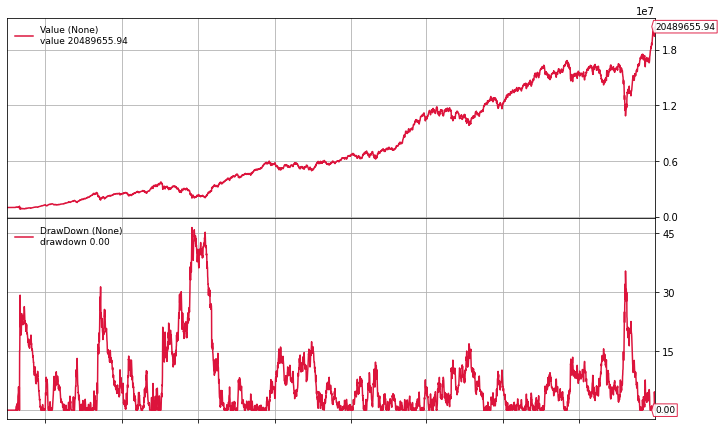

In [ ]:
############################################################
# Backtesting Mean Variance Strategy
############################################################

assets = returns.columns.tolist()
weights = models['MV']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [ ]:
############################################################
# Show Mean Variance Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 46.45%
CAGR: 15.85%
Sharpe: 0.677


array([<AxesSubplot:ylabel='5174'>], dtype=object)

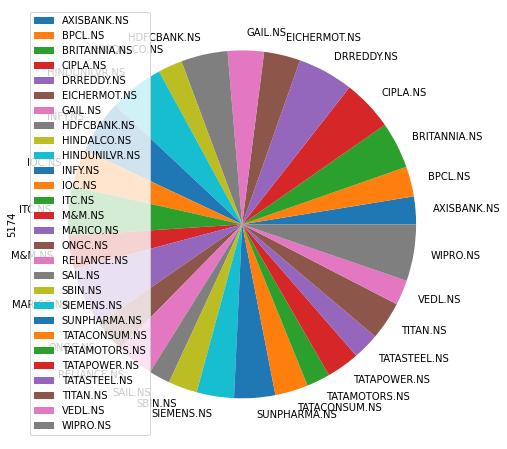

In [ ]:
############################################################
# Plotting the composition of the last MV portfolio
############################################################

w = pd.DataFrame(models['MV'].iloc[-1,:])

# We need matplotlib >= 3.3.0 to use this function
#ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
#                 height=6, width=10, ax=None)

w.plot.pie(subplots=True, figsize=(8, 8))

In [ ]:
############################################################
# Composition per Industry
############################################################

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes = w_classes.groupby(['Industry']).sum()
w_classes.columns = ['weights']
display(w_classes)

,weights
Industry,
Consumer Discretionary,9.6912%
Consumer Staples,9.9120%
Energy,3.3722%
Financials,28.6559%
Health Care,8.4850%
Health care,2.9976%
Industrials,16.6251%
Information Technology,4.6673%
Materials,3.4633%
